# Delta Hedging 

In this notebook we will investigate the effects of delta hedging on European options. 

We will look at options on Apple stock.  

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from _utils import *
from _fitting import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# tickers for the Apple
ticker = "AAPL"
option_ticker = "AAPL"

interval = "1d"
end_date = dt.datetime.today()
start_date = end_date -  dt.timedelta(days = 300)

# Get yesterdays price data for the S&P 500
data = get_stock_data(ticker, start_date, end_date, interval)
data.index = data.index.date

# get at the money price
S0 = data['Close'].values[-1]
data['log_close'] = np.log(data['Close']/S0)

# Get interest rate
r = get_repo_rate(end_date-dt.timedelta(days=7), end_date).values[0,0]/(252*100)

# Get some rough estimates of mu and sigma
mu, sigma = estimate_coeffs(data['log_close'], len(data['log_close']), 1)

#---------------------#
Getting underlying data for ticker:  AAPL
#---------------------#
[*********************100%***********************]  1 of 1 completed


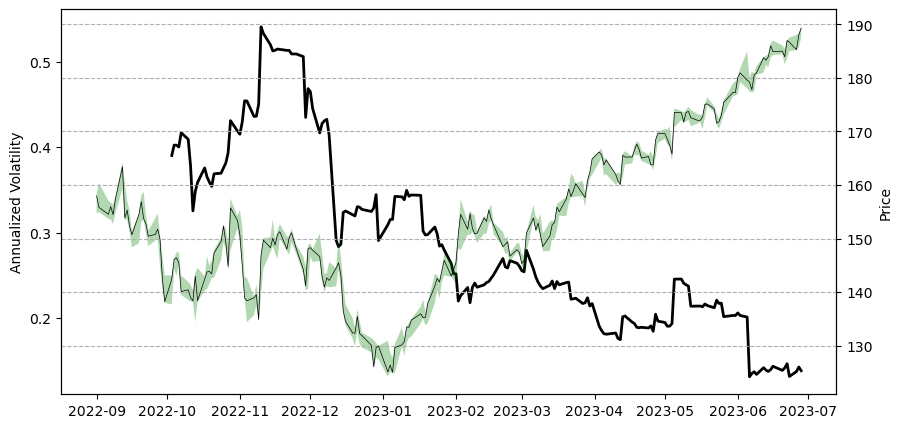

In [3]:
# We now want to get the realised volatility over the last 30 days
data['log_return'] = np.log(data['Close']) - np.log(data['Close'].shift(1))
data['volatility'] = data['log_return'].rolling(21).std() * np.sqrt(252)


fig = plt.figure(figsize=(10, 5))
plt.plot(data['volatility'], color='k', linewidth=2)
plt.ylabel('Annualized Volatility')
# on seperate axis plot the price
ax2 = plt.twinx()
ax2.plot(data['Close'], color='k', linewidth=0.5)
ax2.fill_between(data.index, data['Low'], data['High'], facecolor='g', alpha=0.3)
ax2.set_ylabel('Price')

plt.grid(linestyle='--')
plt.show()

In [4]:
# get expirey date within tau days of yesterday
tau = 77
tau_trading = 55
dtau = 5
expiry_date = (dt.datetime.today() + dt.timedelta(days=tau)).date()
e =  dt.datetime.today() + dt.timedelta(days=tau)

options = get_options_data(option_ticker, expiry_date, 'call')

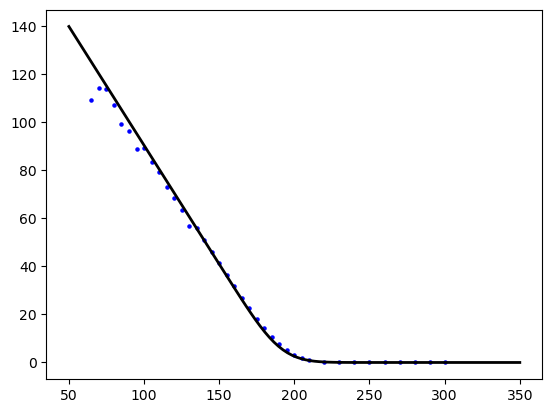

In [5]:
idx = np.abs(options.index - S0).argmin()
option = options.iloc[idx]

# We now purchase the option, which controls 100 shares so the price is 
C0 = option['lastPrice']
K = option.name
X0 = C0
# we will assume the volatility is the same as the last realised volatility
vol = data['volatility'].values[-1]/(100/55**0.5)


K_vals = np.linspace(50, 350, 100)
# define a function that returns greeks using black scholes
call_price = OptionsPriceBSM(S0, K_vals, tau_trading, vol, r, option_type='call')

plt.scatter(options.index, options['lastPrice'], color='b', s=5)
plt.plot(K_vals, call_price, color='k', linewidth=2)

plt.show()

The wealth equation for a delta hedged portfolio is given by:
$$
dX = \Delta dS + r(X - \Delta S)dt
$$
where $X$ is the value of the portfolio, $\Delta$ is the number of shares of the underlying asset, $S$, and $r$ is the risk-free rate.

Now, suppose we want to purchase an at the money, call option. Here we want to hold the option until the maturity which is in 11 weeks. Each week, we will go to the market and delta hedge our portfolio. We will assume the standard options multiplier of 100, thus each option controls 100 shares of the underlying asset.

In [16]:
# Assuming geometric brownian motion, we can simulate the stock price
# over the next 77 days which is 60 trading days
n = 1
t = np.arange(0, tau_trading+dtau, dtau) 

# simulate the stock price assuming no drift
St = stockprice_evolution(S0, t, dtau, 0.000, vol, n)

# define a function that returns greeks using black scholes
Ct = OptionsPriceBSM(St, K, t[::-1], vol, r, option_type='call')
deltat = OptionDeltaBSM(St, K, t[::-1], vol, r, option_type='call')
deltat = np.round(100*deltat, 0).astype(int)

# Compute evolution of wealth over time
Xt = np.zeros((n, len(t)))
Xt[:, 0] = C0*100
dr = np.exp(r*dtau)

    


/Users/michael/Dropbox/Work/Projects/Finance/Projects/Hedging_API/_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S0 / K) + (r + sigma**2 / 2) * tau) / (sigma * np.sqrt(tau))
/Users/michael/Dropbox/Work/Projects/Finance/Projects/Hedging_API/_utils.py:194: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S0 / K) + (r + sigma**2 / 2) * tau) / (sigma * np.sqrt(tau))


In [17]:
# create a dataframe to store the data with index name as week 
df = pd.DataFrame(index=np.arange(len(t)), columns=['Stock Price', 'Option Price', 'Delta'])
df.index.name = 'Week'
df['Stock Price'] = St[0]
df['Option Price'] = Ct[0]
df['Delta'] = -deltat[0]
df['Delta Adjustments'] = df['Delta'].diff()
df['Total Delta Adjustment'] = df.loc[0, 'Delta'] - df['Delta']
df['Adjustment Cashflow'] = df['Delta Adjustments']*df['Stock Price']*dr
df['Interest on Cash'] = df['Adjustment Cashflow']*(dr-1)
df['Net Position'] = df['Delta'] * df['Stock Price']  + 100*df.loc[0, 'Option Price'] 

df

,Stock Price,Option Price,Delta,Delta Adjustments,Total Delta Adjustment,Adjustment Cashflow,Interest on Cash,Net Position
Week,,,,,,,,
0,189.300003,6.450939,-55,NaN,0,NaN,NaN,-9766.406230
1,190.218252,6.603333,-58,-3.0,3,-571.229097,-0.574918,-10387.564695
2,187.690522,4.872064,-50,8.0,-5,1503.035400,1.512743,-8739.432177
3,188.302845,4.793576,-51,-1.0,-4,-188.492364,-0.189710,-8958.351149
4,181.321892,1.734868,-27,24.0,-28,4356.105235,4.384239,-4250.597141
5,184.235468,2.274017,-34,-7.0,-21,-1290.946257,-1.299284,-5618.911989
6,184.296597,1.908214,-32,2.0,-23,368.964168,0.371347,-5252.397178
7,191.497682,4.733620,-61,-29.0,6,-5559.022080,-5.594925,-11036.264668
8,188.825484,2.709125,-48,13.0,-7,2457.201882,2.473072,-8418.529310


In [18]:
OrigPNL = 100*(X0 - np.maximum(St[0,-1]-K,0))
carry_int_options = (np.exp(r*tau_trading) - 1)*C0*100

df['Adjustment Cashflow'].sum()


-9338.54538015457

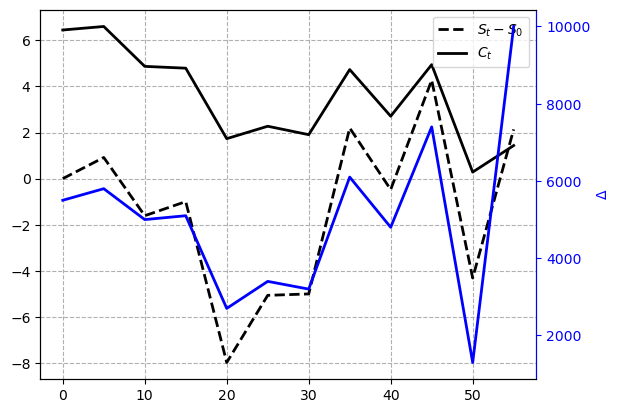

In [19]:
ix = 0
plt.plot(t, (St- S0)[ix], color='k', linewidth=2, linestyle='--', label=r'$S_{t} - S_{0}$')
plt.plot(t, Ct[ix], color='k', linewidth=2, label=r'$C_{t}$')

plt.legend()
plt.grid(linestyle='--')

ax2 = plt.twinx()
ax2.plot(t, 100*deltat[ix], color='b', linewidth=2)
ax2.set_ylabel(r'$\Delta$', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
# ax2.set_ylim(0, 1)


plt.show()

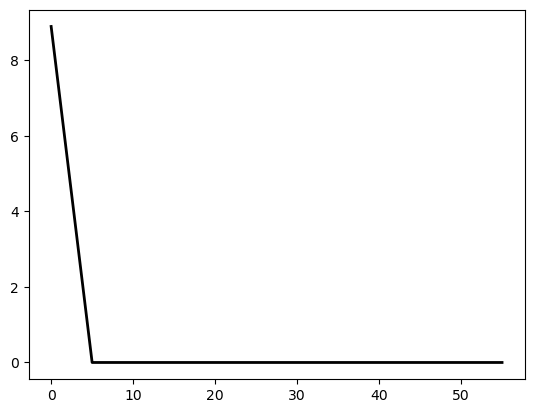

In [231]:
plt.plot(t, Xt[ix], color='k', linewidth=2, label=r'$X_{t}$')

plt.show()